In [1]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import conversion_equations as ce
import pickle
import os
from matplotlib.colors import Normalize
import ast
import seaborn as sns

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

starve_metabs = pd.read_excel('../data/validation_data_sets/stationary_phase/metabolites_data.xlsx', index_col = 0)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

flags_df = pd.read_csv('../data/saved_flags_expanded_curated.csv', index_col = 0)
flags_df = flags_df[flags_df['include']]

TF_flags_df = pd.read_csv('../data/TF_saved_flags_expanded.csv', index_col = 0)

In [2]:
# first we need to make a ratio df
if True: # change to True to run again
    cases = set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()])
    collect_actuals = []
    collect_predictions = []
    for iMs_run in cases:
        clean = [x for x in iMs_run if str(x) != 'nan']
        case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
        if not os.path.exists('../GAMs/optimization_runs/'+case):
            continue

        # let's find our run_dir
        try:
            iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
            run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
            GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
            mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        except:
            continue # Usually means it hasn't been run yet
        actual_ratio = ce.log_tpm_df_to_mRNA_ratio_df(log_tpm_df.loc[mRNA_df.columns], flags_df.loc[mRNA_df.columns])

        collect_actuals.append(actual_ratio)
        collect_predictions.append(mRNA_df)

    merge_actual = pd.concat(collect_actuals, axis = 1)
    merge_pred = pd.concat(collect_predictions, axis = 1)
    overlap = list(set(merge_actual.index).intersection(set(merge_pred.index)))
    actual_mRNA_df = merge_actual.loc[:,~merge_actual.columns.duplicated()].astype(float)
    pred_mRNA_df = merge_pred.loc[:,~merge_pred.columns.duplicated()].astype(float)

    # create sample-sample and gene-gene correlation dataframe
    sample_corr_df = pd.DataFrame(index = actual_mRNA_df.index, columns = actual_mRNA_df.index)
    for sample1 in actual_mRNA_df.index:
        for sample2 in actual_mRNA_df.index:
            sample_corr_df.at[sample1, sample2] = actual_mRNA_df.loc[sample1].corr(pred_mRNA_df.loc[sample2])
    gene_corr_df = pd.DataFrame(index = actual_mRNA_df.columns, columns = actual_mRNA_df.columns)
    for sample1 in actual_mRNA_df.columns:
        for sample2 in actual_mRNA_df.columns:
            gene_corr_df.at[sample1, sample2] = actual_mRNA_df[sample1].corr(pred_mRNA_df[sample2])

    # these things take a while to run, let's save them off
    sample_corr_df.to_csv('../data/samples_correlation_df.csv')
    gene_corr_df.to_csv('../data/genes_correlation_df.csv')
else:
    # load in
    sample_corr_df = pd.read_csv('../data/samples_correlation_df.csv', index_col = 0)
    gene_corr_df = pd.read_csv('../data/genes_correlation_df.csv', index_col = 0)

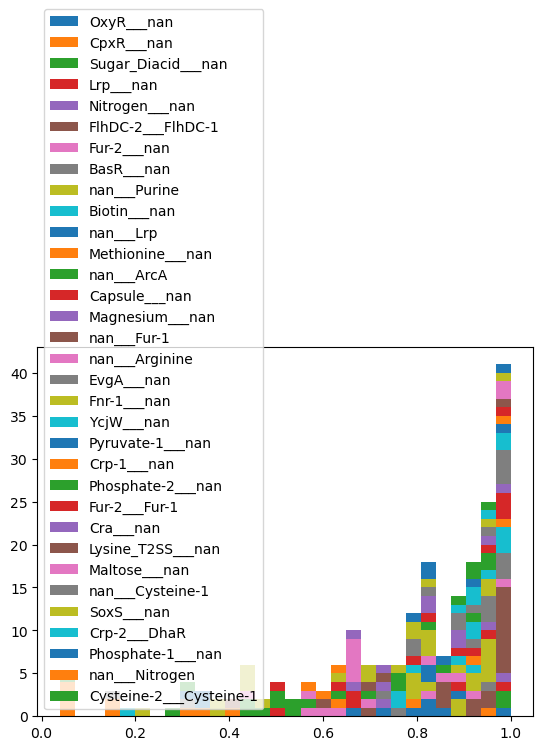

In [3]:
# stacked histogram - try rerunning once all samples run

case_to_genes = {}
case_to_avr_corr = {}
plot_vals = []
plot_labels = []
for iMs_run in set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
    # let's find our run_dir
    try:
        iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
        run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
        mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    except:
        continue # Usually means it hasn't been run yet
    plot_labels.append(case)
    plot_vals.append(np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]))
    case_to_avr_corr.update({case : np.mean(np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]))})
plt.hist(plot_vals, stacked = True, bins = 30, label = plot_labels)
plt.legend()
plt.show()

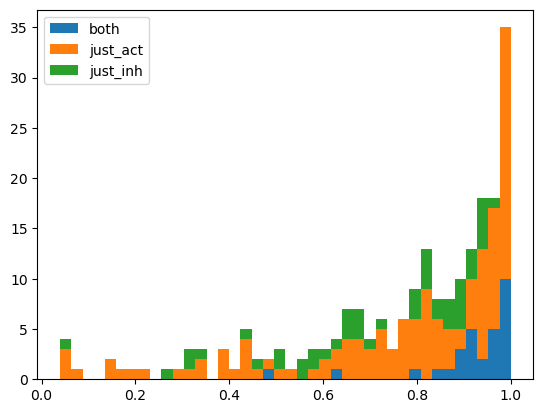

In [4]:
# same as above, but split by case type (dual regulator, all inhibitor, all activator)

type_to_cases = {
    'both' : [],
    'just_act' : [],
    'just_inh' : []
}
for iMs_run in set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()]):
    if str(iMs_run[0]) != 'nan' and str(iMs_run[1]) != 'nan':
        type_to_cases['both'].append(iMs_run)
    elif str(iMs_run[0]) != 'nan' and str(iMs_run[1]) == 'nan':
        type_to_cases['just_act'].append(iMs_run)
    elif str(iMs_run[0]) == 'nan' and str(iMs_run[1]) != 'nan':
        type_to_cases['just_inh'].append(iMs_run)
plot_vals = []
plot_labels = []
for type, cases in type_to_cases.items():
    plot_labels.append(type)
    temp_plot_vals = []
    for iMs_run in cases:
        case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
        # let's find our run_dir
        try:
            iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
            run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
            GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
            mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        except:
            continue # Usually means it hasn't been run yet
        for val in np.diag(gene_corr_df.loc[mRNA_df.columns][mRNA_df.columns]):
            temp_plot_vals.append(val)
    plot_vals.append(temp_plot_vals)
plt.hist(plot_vals, stacked = True, bins = 40, label = plot_labels)
plt.legend()
plt.savefig('../figures/gene_pred_corrs_histogram.pdf', transparent = True)
plt.show()

In [6]:
# what's wrong with the terrible ones?
worst_cases = [k for k, _ in sorted(case_to_avr_corr.items(), key = lambda k : k[1])]
for case in worst_cases:
    print(case+' : '+str(case_to_avr_corr[case]))

CpxR___nan : 0.301441714376028
nan___ArcA : 0.4083717153225279
Crp-1___nan : 0.5747694323259789
nan___Nitrogen : 0.6013679069356074
SoxS___nan : 0.6174286648821876
nan___Lrp : 0.6597266399222557
Pyruvate-1___nan : 0.6706441210087507
Lysine_T2SS___nan : 0.6992608279472404
Phosphate-2___nan : 0.6996310419575699
Lrp___nan : 0.7054358771564306
nan___Arginine : 0.7143071887402124
nan___Fur-1 : 0.7466030759245006
Fur-2___nan : 0.757916306708747
Fur-2___Fur-1 : 0.7995073425743434
Maltose___nan : 0.8011898154287489
OxyR___nan : 0.8084283723107992
BasR___nan : 0.8116593390565912
YcjW___nan : 0.8181717101886615
Cra___nan : 0.820573778499465
Magnesium___nan : 0.8303875308785374
Fnr-1___nan : 0.8459289039468157
Nitrogen___nan : 0.8535954668266006
nan___Cysteine-1 : 0.8610074776754811
Phosphate-1___nan : 0.8679930517565048
EvgA___nan : 0.874789139416064
Methionine___nan : 0.91221240223478
Crp-2___DhaR : 0.918058515694116
nan___Purine : 0.9181944667756226
Cysteine-2___Cysteine-1 : 0.9216121814190705